## Data cleaning of current sub-Neptune spectra
**Author: Nestor Espinoza | Date: March, 2025**

Motivation of this notebook: the classic problem. All data is in different formats. In this notebook, we convert all data to a common format (a dictionary) that then we use in our plotting script.

It's a bit messy, but it's honest work.

# 1. Introductory work

First, define libraries:


In [1]:
import pickle
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns 
sns.set_style('ticks')

import h5py
import netCDF4 as nc

import matplotlib as mpl 

from scipy.ndimage import gaussian_filter, median_filter

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

In [2]:
from POSEIDON.core import create_star, create_planet, define_model, make_atmosphere, read_opacities, wl_grid_constant_R, compute_spectrum
from POSEIDON.constants import R_Sun, R_E, M_E 

[rakisduam.stsci.edu:31770] shmem: mmap: an error occurred while determining whether or not /var/folders/y5/_ldk3z5d46qf_8jkyqk5trbw0002dd/T//ompi.rakisduam.2477/jf.0/4106092544/sm_segment.rakisduam.2477.f4be0000.0 could be created.


In [3]:
# Define star/planet atmospheric properties:
star_properties = {}

# From Berger+2018
star_properties['R'] = 0.539
star_properties['Teff'] = 3788
star_properties['FeH'] = -0.28
star_properties['logg'] = 4.770

planet_properties = {}

planet_properties['R'] = 1.438 # Rearth
planet_properties['M'] = 3.04 # obtained with spright
planet_properties['T_eq'] = 200 # K 

# Atmosphere is hydrogen-dominated by default:
bulk_species = ['N2']                                      # For terrestrial planets, only the single most abundant gas should be provided here
param_species = ['O2', 'CO2', 'CH4', 'H2O', 'O3', 'N2O'] 

# Haze properties fixed:
log_a, gamma = np.log10(1.), -4

In [4]:
class generate_atmosphere:

    def set_parameters(self, T, log_X, cloud_parameters, P_ref = None):

        if P_ref is None:

            P_ref = self.P_ref

        self.T = T
        self.log_X = log_X
        self.cloud_parameters = cloud_parameters

        PT_params = np.array([T])

        self.atmosphere = make_atmosphere(self.planet, self.model, self.P, P_ref, self.R_p_ref,
                                          PT_params, log_X,  cloud_params=cloud_parameters)

    def get_spectrum(self):

        return compute_spectrum(self.planet, self.star, self.model, self.atmosphere, self.opac, self.wl,
                                spectrum_type = 'transmission')

    def __init__(self, star_properties, planet_properties, param_species, bulk_species,
                 PT_profile = 'isotherm', cloud_model = 'MacMad17', cloud_type = 'deck_haze', cloud_dim = 1,
                 P_min = 1e-7, P_max = 100, N_layers = 100, P_surf = 100.0, wl_min = 0.5, wl_max = 5.7, R = 10000,
                 planet_name = 'myplanet', model_name = 'mymodel'):

        # Load stellar properties:
        self.R_s = star_properties['R'] * R_Sun
        self.T_s = star_properties['Teff']
        self.Met_s = star_properties['FeH']
        self.log_g_s = star_properties['logg']

        # Load planet properties:
        self.R_p = planet_properties['R'] * R_E
        self.M_p = planet_properties['M'] * M_E
        self.T_eq = planet_properties['T_eq']

        # Save parameters for posteriety:
        self.param_species = param_species
        self.bulk_species = bulk_species

        # Create star and planet:
        self.star = create_star(self.R_s, self.T_s, self.log_g_s, self.Met_s)
        self.planet = create_planet(planet_name, self.R_p, mass = self.M_p, T_eq = self.T_eq)


        self.model = define_model(model_name, bulk_species, param_species,
                                  PT_profile = PT_profile,
                                  cloud_model = cloud_model,
                                  cloud_type = cloud_type,
                                  cloud_dim = cloud_dim)

        self.wl = wl_grid_constant_R(wl_min, wl_max, R)

        # Read opacity:
        opacity_treatment = 'opacity_sampling'

        # Define fine temperature grid (K)
        T_fine_min = 100     # 100 K lower limit covers the TRAPPIST-1e P-T profile
        T_fine_max = 1000     # 300 K upper limit covers the TRAPPIST-1e P-T profile
        T_fine_step = 10     # 10 K steps are a good tradeoff between accuracy and RAM

        T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

        # Define fine pressure grid (log10(P/bar))
        log_P_fine_min = -6.0   # 1 ubar is the lowest pressure in the opacity database
        log_P_fine_max = 2.0    # 1 bar is the surface pressure, so no need to go deeper
        log_P_fine_step = 0.2   # 0.2 dex steps are a good tradeoff between accuracy and RAM

        log_P_fine = np.arange(log_P_fine_min, (log_P_fine_max + log_P_fine_step), log_P_fine_step)

        self.opac = read_opacities(self.model, self.wl, opacity_treatment, T_fine, log_P_fine)#, opacity_database = 'Temperate')

        # Set atmosphere --- first, set initial values:
        self.P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)
        self.P_ref = P_surf
        self.R_p_ref = self.R_p

        T_init = 300.
        # this sets by hand the number of opacities --- FIXME to generalize inputs:
        log_X_init = np.log10( np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1] ) )
        a, Pcloud = 1., 1e6
        log_a, gamma, log_P_cloud = np.log10(a), -4., np.log10(Pcloud)
        self.log_a, self.gamma, self.log_P_cloud = np.log10(a), -4., np.log10(Pcloud)

        cloud_params_init = [self.log_a, self.gamma, self.log_P_cloud]

        self.set_parameters(T_init, log_X_init, cloud_params_init)

In [5]:
planet = generate_atmosphere(star_properties, planet_properties, param_species, bulk_species, R = 500)
wavelengths_model = planet.wl

Reading in cross sections in opacity sampling mode...
CO2-CO2 done
CO2-CH4 done
N2-N2 done
N2-H2O done
O2-O2 done
O2-CO2 done
O2-N2 done
O2 done
CO2 done
CH4 done
H2O done
O3 done
N2O done
Opacity pre-interpolation complete.


In [6]:
# Taken from modern Earth's model: https://github.com/MartianColonist/POSEIDON/blob/main/POSEIDON/reference_data/models/TRAPPIST-1e/TRAPPIST-1e_1.0bar_100xCO2_Modern_chem.txt
pressure, N2, O2, O3, H2O, CH4, N2O, CO2, CO = 0.001087,\
                                               0.75394509, 0.21, 6.741E-06, 7.364E-06, 2.201E-05, 3.25E-07, 3.60E-02, 1.847E-05

T = 250. 
logPcloud, logP_ref = 1., 2.
log_X = np.log10( np.array([O2, CO2, CH4, H2O, O3, N2O]) )
P_ref = 10**(logP_ref)
planet.set_parameters(T, log_X, [log_a, gamma, logPcloud], P_ref = P_ref)
model_10barclouds = planet.get_spectrum() * 1e6
filtered_model_10barclouds = gaussian_filter(median_filter(model_10barclouds,10), 2)

In [7]:
# Models with 0.1 bar clouds:
logPcloud = 0
planet.set_parameters(T, log_X, [log_a, gamma, logPcloud], P_ref = P_ref)
model_1barclouds = planet.get_spectrum() * 1e6
filtered_model_1barclouds = gaussian_filter(median_filter(model_1barclouds,10), 2)

In [8]:
# Models with 0.1 bar clouds:
logPcloud = -1
planet.set_parameters(T, log_X, [log_a, gamma, logPcloud], P_ref = P_ref)
model_1barclouds = planet.get_spectrum() * 1e6
filtered_model_01barclouds = gaussian_filter(median_filter(model_1barclouds,10), 2)

In [9]:
# Models with 0.1 bar clouds:
logPcloud = -6
planet.set_parameters(T, log_X, [log_a, gamma, logPcloud], P_ref = P_ref)
model_1barclouds = planet.get_spectrum() * 1e6
filtered_model_0001mbarbarclouds = gaussian_filter(median_filter(model_1barclouds,10), 2)

In [10]:
palette = sns.color_palette("Paired")
sns.set_palette(palette) 

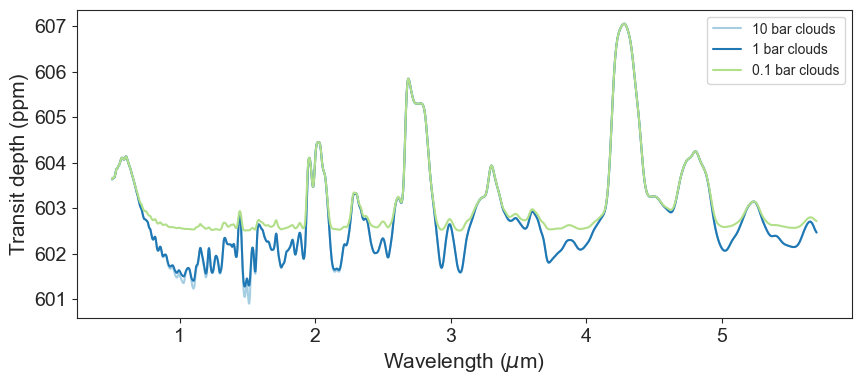

In [11]:
plt.figure(figsize=(10,4))


plt.plot(wavelengths_model, filtered_model_10barclouds, label = '10 bar clouds')
plt.plot(wavelengths_model, filtered_model_1barclouds, label = '1 bar clouds')
plt.plot(wavelengths_model, filtered_model_01barclouds, label = '0.1 bar clouds')

plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('Wavelength ($\mu$m)',fontsize = 15)
plt.ylabel('Transit depth (ppm)',fontsize = 15)
plt.legend()

What about a Venus-like atmosphere?

In [12]:
# Atmosphere is hydrogen-dominated by default:
bulk_species = ['CO2']                                      # For terrestrial planets, only the single most abundant gas should be provided here
param_species = ['N2', 'O2', 'CH4', 'H2O', 'O3', 'N2O'] 

# Haze properties fixed:
log_a, gamma = np.log10(1.), -4

In [13]:
N2 = 3.5/100
H2O = 20*1e-6
O2 = 1*1e-9
CH4 = 1*1e-9
O3 = 1*1e-9
N2O = 1*1e-9

In [14]:
planet = generate_atmosphere(star_properties, planet_properties, param_species, bulk_species, R = 500)
wavelengths_model = planet.wl

Reading in cross sections in opacity sampling mode...
CO2-CO2 done
CO2-CH4 done
N2-N2 done
N2-H2O done
O2-O2 done
O2-CO2 done
O2-N2 done
CO2 done
O2 done
CH4 done
H2O done
O3 done
N2O done
Opacity pre-interpolation complete.


In [15]:
T = 250. 
logPcloud, logP_ref = 1., 2.
log_X = np.log10( np.array([N2,O2,CH4,H2O,O3,N2O]) )
P_ref = 10**(logP_ref)
planet.set_parameters(T, log_X, [log_a, gamma, logPcloud], P_ref = P_ref)
venus_model_10barclouds = planet.get_spectrum() * 1e6
venus_filtered_model_10barclouds = gaussian_filter(median_filter(venus_model_10barclouds,10), 2)

In [16]:
# Models with 0.1 bar clouds:
logPcloud = 0
planet.set_parameters(T, log_X, [log_a, gamma, logPcloud], P_ref = P_ref)
venus_model_1barclouds = planet.get_spectrum() * 1e6
venus_filtered_model_1barclouds = gaussian_filter(median_filter(venus_model_1barclouds,10), 2)

In [17]:
# Models with 0.1 bar clouds:
logPcloud = -1
planet.set_parameters(T, log_X, [log_a, gamma, logPcloud], P_ref = P_ref)
venus_model_1barclouds = planet.get_spectrum() * 1e6
venus_filtered_model_01barclouds = gaussian_filter(median_filter(venus_model_1barclouds,10), 2)

In [18]:
# Models with 0.1 bar clouds:
logPcloud = -6
planet.set_parameters(T, log_X, [log_a, gamma, logPcloud], P_ref = P_ref)
venus_model_1barclouds = planet.get_spectrum() * 1e6
venus_filtered_model_0001mbarbarclouds = gaussian_filter(median_filter(venus_model_1barclouds,10), 2)

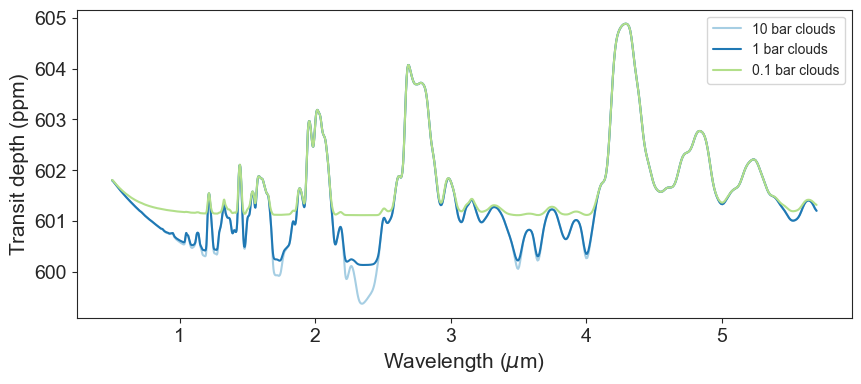

In [19]:
plt.figure(figsize=(10,4))


plt.plot(wavelengths_model, venus_filtered_model_10barclouds, label = '10 bar clouds')
plt.plot(wavelengths_model, venus_filtered_model_1barclouds, label = '1 bar clouds')
plt.plot(wavelengths_model, venus_filtered_model_01barclouds, label = '0.1 bar clouds')

plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('Wavelength ($\mu$m)',fontsize = 15)
plt.ylabel('Transit depth (ppm)',fontsize = 15)
plt.legend()

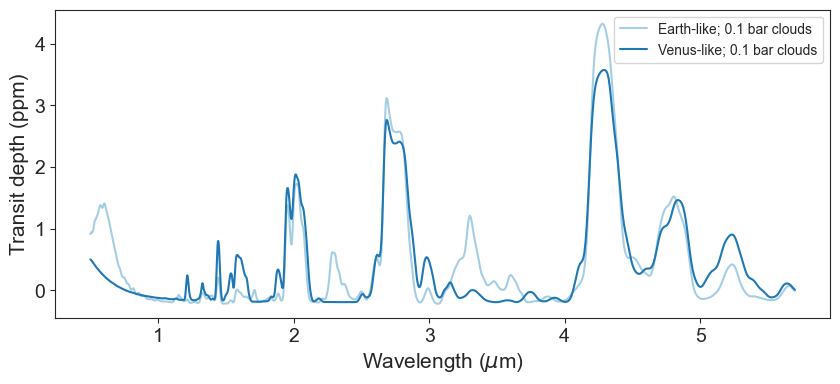

In [20]:
plt.figure(figsize=(10,4))

plt.plot(wavelengths_model, filtered_model_01barclouds - np.nanmedian(filtered_model_01barclouds), label = 'Earth-like; 0.1 bar clouds')
plt.plot(wavelengths_model, venus_filtered_model_01barclouds - np.nanmedian( venus_filtered_model_01barclouds ), label = 'Venus-like; 0.1 bar clouds')

plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('Wavelength ($\mu$m)',fontsize = 15)
plt.ylabel('Transit depth (ppm)',fontsize = 15)
plt.legend()